
# 🌱 Smart Irrigation System with TinyML

## Project Overview

This notebook builds an **intelligent irrigation scheduling system** that:
1. **Predicts future irrigation needs** based on sensor trends (not just current values)
2. **Deploys to ESP32** microcontroller using TensorFlow Lite
3. **Uses temporal patterns** to make proactive decisions

### Why Trend-Based Forecasting?

Simple threshold systems only see the present:
> "Moisture is 220 → Is it below 250? → Yes → Irrigate"

Our approach sees the **trajectory**:
> "Moisture is 220, was 280 an hour ago, dropping fast → Will need irrigation soon!"

---
"""


In [1]:
# ============================================================================
# 1.Install Dependencies & Imports
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📦 TensorFlow version: {tf.__version__}")


✅ All libraries imported successfully!
📦 TensorFlow version: 2.19.0


In [2]:
# ============================================================================
# 2. Load Data
# ============================================================================

df = pd.read_csv('Irrigation Scheduling.csv')

print(f"📁 Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("\n📋 Column names:")
print(df.columns.tolist())

📁 Dataset loaded: 4688 rows, 10 columns

📋 Column names:
['id', 'temperature', 'pressure', 'altitude', 'soilmiosture', 'note', 'status', 'class', 'date', 'time']


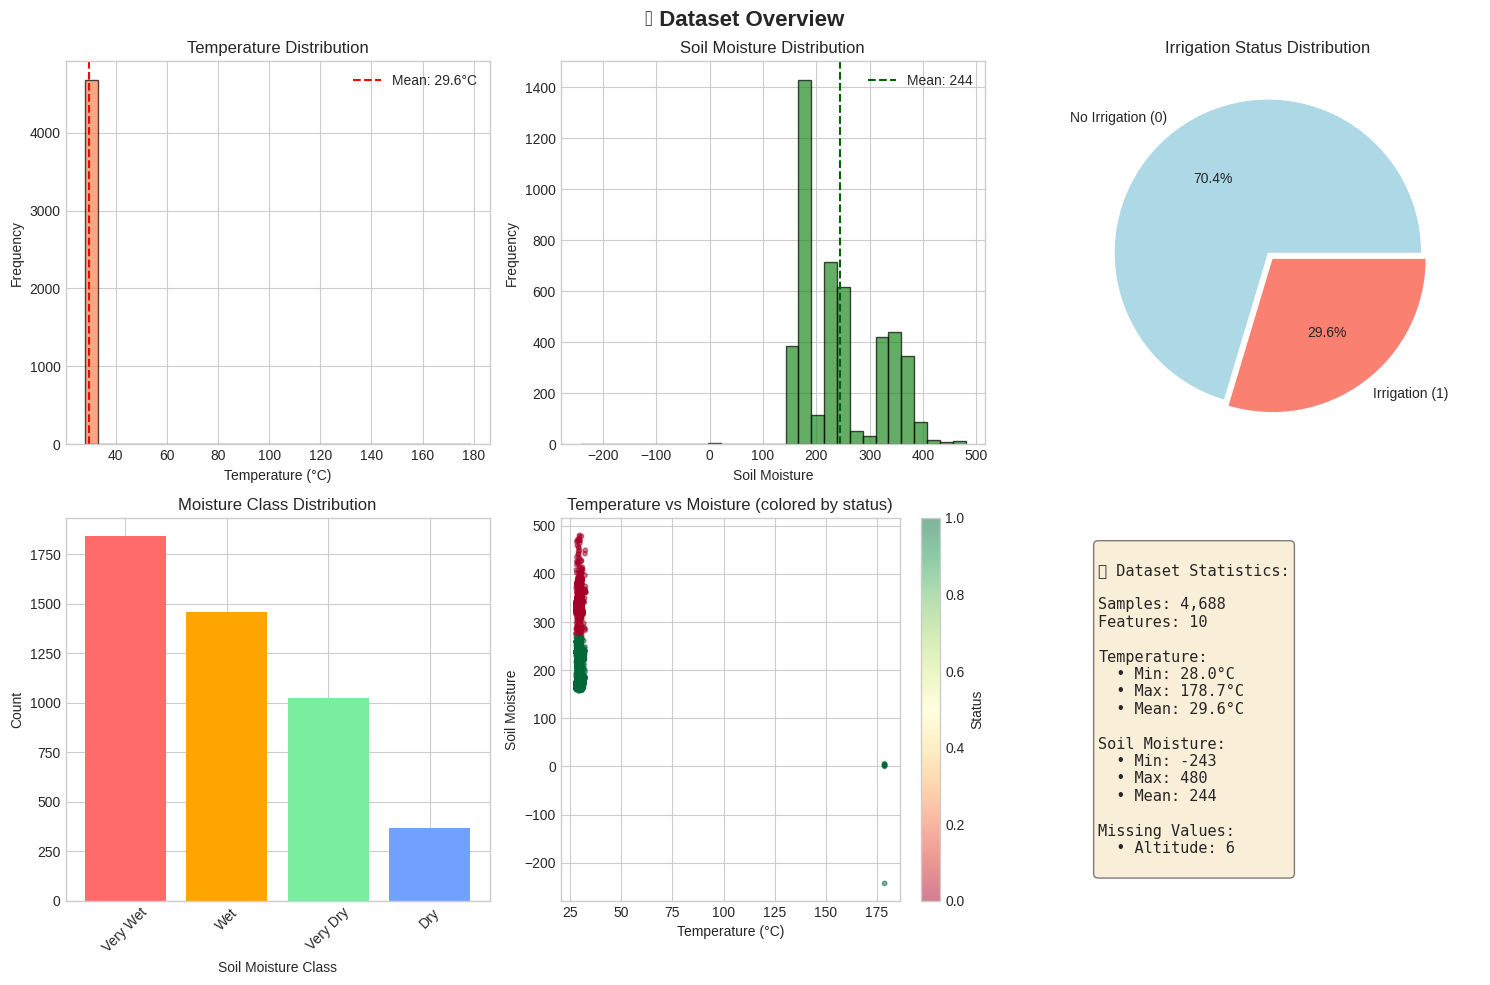

💾 Saved: 01_data_overview.png


In [3]:
# ============================================================================
# 3. Data Overview Visualization
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('📊 Dataset Overview', fontsize=16, fontweight='bold')

# Plot 1: Temperature distribution
axes[0, 0].hist(df['temperature'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Temperature Distribution')
axes[0, 0].axvline(df['temperature'].mean(), color='red', linestyle='--', label=f'Mean: {df["temperature"].mean():.1f}°C')
axes[0, 0].legend()

# Plot 2: Soil Moisture distribution
axes[0, 1].hist(df['soilmiosture'], bins=30, color='forestgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Soil Moisture')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Soil Moisture Distribution')
axes[0, 1].axvline(df['soilmiosture'].mean(), color='darkgreen', linestyle='--', label=f'Mean: {df["soilmiosture"].mean():.0f}')
axes[0, 1].legend()

# Plot 3: Status (irrigation needed) distribution
status_counts = df['status'].value_counts()
axes[0, 2].pie(status_counts, labels=['No Irrigation (0)', 'Irrigation (1)'],
               autopct='%1.1f%%', colors=['lightblue', 'salmon'], explode=[0, 0.05])
axes[0, 2].set_title('Irrigation Status Distribution')

# Plot 4: Class distribution
class_counts = df['class'].value_counts()
axes[1, 0].bar(class_counts.index, class_counts.values, color=['#ff6b6b', '#ffa502', '#7bed9f', '#70a1ff'])
axes[1, 0].set_xlabel('Soil Moisture Class')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Moisture Class Distribution')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 5: Temperature vs Moisture scatter
scatter = axes[1, 1].scatter(df['temperature'], df['soilmiosture'],
                              c=df['status'], cmap='RdYlGn', alpha=0.5, s=10)
axes[1, 1].set_xlabel('Temperature (°C)')
axes[1, 1].set_ylabel('Soil Moisture')
axes[1, 1].set_title('Temperature vs Moisture (colored by status)')
plt.colorbar(scatter, ax=axes[1, 1], label='Status')

# Plot 6: Data info text
axes[1, 2].axis('off')
info_text = f"""
📈 Dataset Statistics:

Samples: {len(df):,}
Features: {df.shape[1]}

Temperature:
  • Min: {df['temperature'].min():.1f}°C
  • Max: {df['temperature'].max():.1f}°C
  • Mean: {df['temperature'].mean():.1f}°C

Soil Moisture:
  • Min: {df['soilmiosture'].min():.0f}
  • Max: {df['soilmiosture'].max():.0f}
  • Mean: {df['soilmiosture'].mean():.0f}

Missing Values:
  • Altitude: {df['altitude'].isna().sum()}
"""
axes[1, 2].text(0.1, 0.5, info_text, fontsize=11, verticalalignment='center',
                fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('01_data_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: 01_data_overview.png")

In [4]:
# ============================================================================
# 4. Data Preprocessing
# ============================================================================

print("🔧 PREPROCESSING DATA")
print("=" * 50)

data = df.copy()

# Convert datetime
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'],
                                   format='%d-%m-%Y %H:%M:%S', errors='coerce')
data = data.sort_values('datetime').reset_index(drop=True)
print(f"✓ Sorted data chronologically")

# Handle missing values
missing_before = data['altitude'].isna().sum()
data['altitude'].fillna(data['altitude'].median(), inplace=True)
print(f"✓ Filled {missing_before} missing altitude values with median")

# Remove outliers using IQR method
original_len = len(data)
for col in ['temperature', 'pressure', 'soilmiosture']:
    Q1, Q3 = data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 3*IQR, Q3 + 3*IQR
    before = len(data)
    data = data[(data[col] >= lower) & (data[col] <= upper)]
    removed = before - len(data)
    if removed > 0:
        print(f"✓ Removed {removed} outliers from {col}")

data = data.reset_index(drop=True)
print(f"\n📊 Clean dataset: {len(data)} samples (removed {original_len - len(data)} outliers)")


🔧 PREPROCESSING DATA
✓ Sorted data chronologically
✓ Filled 6 missing altitude values with median
✓ Removed 7 outliers from temperature

📊 Clean dataset: 4681 samples (removed 7 outliers)


In [5]:
# ============================================================================
# 5.Feature Engineering with Visualization
# ============================================================================

print("⏱️ CREATING TIME-SERIES FEATURES")
print("=" * 50)

window_size = 4      # Look at last 4 readings
forecast_horizon = 2  # Predict 2 steps ahead

# Create rolling features
for col in ['temperature', 'soilmiosture']:
    data[f'{col}_mean'] = data[col].rolling(window_size).mean()
    data[f'{col}_trend'] = data[col].diff(periods=window_size)

# Create lag features
for lag in range(1, window_size + 1):
    data[f'soilmiosture_lag_{lag}'] = data['soilmiosture'].shift(lag)

# Create target: FUTURE irrigation status
data['future_status'] = data['status'].shift(-forecast_horizon)

# Remove rows with NaN
data = data.dropna().reset_index(drop=True)

# Define feature columns
feature_cols = [
    'temperature', 'soilmiosture',
    'temperature_mean', 'soilmiosture_mean',
    'temperature_trend', 'soilmiosture_trend',
    'soilmiosture_lag_1', 'soilmiosture_lag_2'
]

print(f"✓ Created {len(feature_cols)} features")
print(f"✓ Forecast horizon: {forecast_horizon} steps ahead")
print(f"✓ Final dataset: {len(data)} samples")

⏱️ CREATING TIME-SERIES FEATURES
✓ Created 8 features
✓ Forecast horizon: 2 steps ahead
✓ Final dataset: 4675 samples


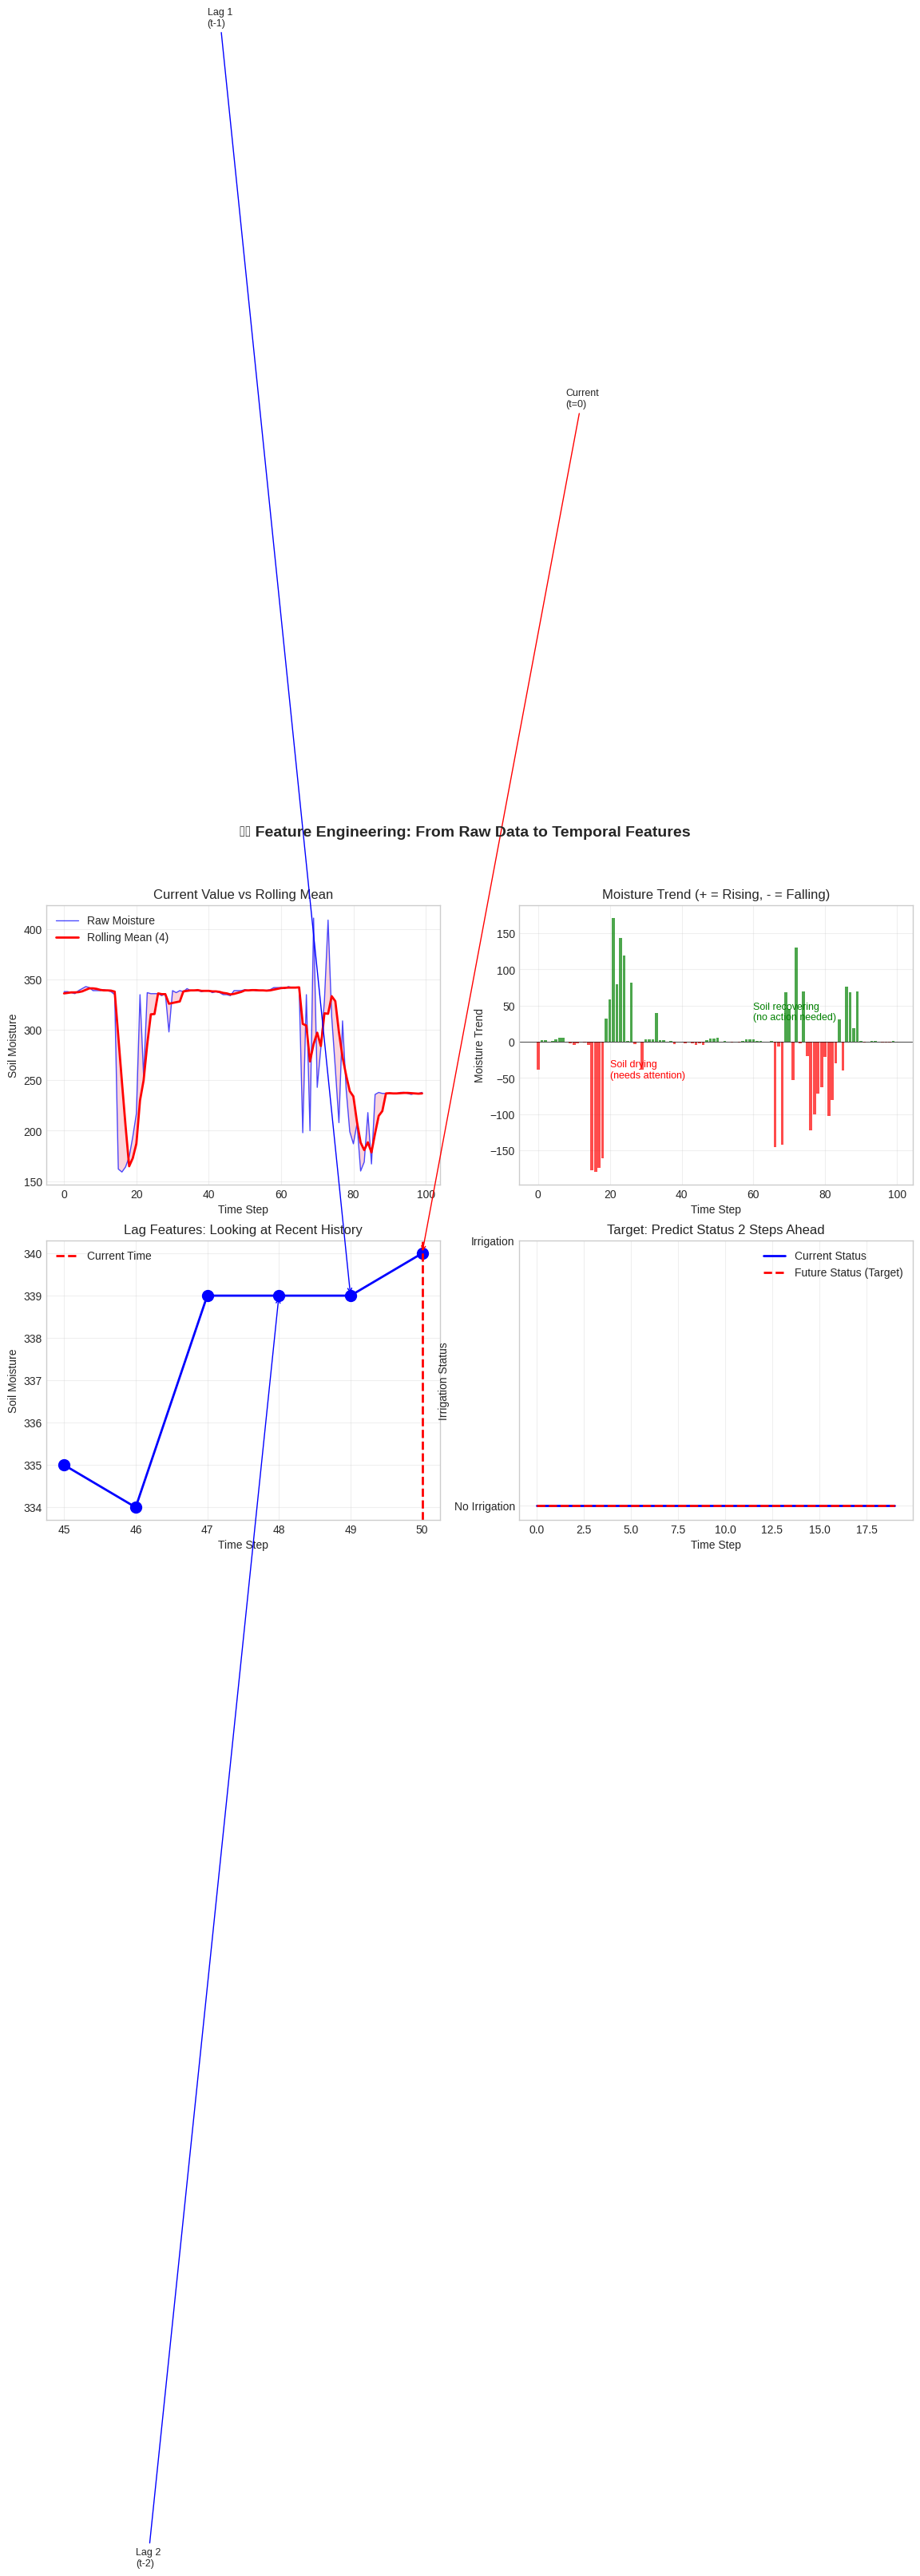

💾 Saved: 02_feature_engineering.png


In [6]:
# ============================================================================
# 6. Visualize Feature Engineering Concept
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('⏱️ Feature Engineering: From Raw Data to Temporal Features',
             fontsize=14, fontweight='bold')

# Sample a portion of data for visualization
sample_size = 100
sample = data.iloc[:sample_size].copy()
x = range(sample_size)

# Plot 1: Raw Moisture vs Rolling Mean
ax1 = axes[0, 0]
ax1.plot(x, sample['soilmiosture'], 'b-', linewidth=1, alpha=0.7, label='Raw Moisture')
ax1.plot(x, sample['soilmiosture_mean'], 'r-', linewidth=2, label='Rolling Mean (4)')
ax1.fill_between(x, sample['soilmiosture'], sample['soilmiosture_mean'], alpha=0.3)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Soil Moisture')
ax1.set_title('Current Value vs Rolling Mean')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Moisture Trend
ax2 = axes[0, 1]
colors = ['green' if t > 0 else 'red' for t in sample['soilmiosture_trend']]
ax2.bar(x, sample['soilmiosture_trend'], color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Moisture Trend')
ax2.set_title('Moisture Trend (+ = Rising, - = Falling)')
ax2.grid(True, alpha=0.3)

# Add annotations
ax2.annotate('Soil drying\n(needs attention)', xy=(20, -50), fontsize=9, color='red')
ax2.annotate('Soil recovering\n(no action needed)', xy=(60, 30), fontsize=9, color='green')

# Plot 3: Lag Features Concept
ax3 = axes[1, 0]
example_idx = 50
lags_to_show = 5
times = list(range(example_idx - lags_to_show, example_idx + 1))
values = [sample['soilmiosture'].iloc[t] if t >= 0 else np.nan for t in times]

ax3.plot(times, values, 'bo-', markersize=10, linewidth=2)
ax3.axvline(x=example_idx, color='red', linestyle='--', linewidth=2, label='Current Time')

# Annotate lags
ax3.annotate('Current\n(t=0)', xy=(example_idx, values[-1]), xytext=(example_idx+2, values[-1]+20),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=9)
ax3.annotate('Lag 1\n(t-1)', xy=(example_idx-1, values[-2]), xytext=(example_idx-3, values[-2]+30),
            arrowprops=dict(arrowstyle='->', color='blue'), fontsize=9)
ax3.annotate('Lag 2\n(t-2)', xy=(example_idx-2, values[-3]), xytext=(example_idx-4, values[-3]-30),
            arrowprops=dict(arrowstyle='->', color='blue'), fontsize=9)

ax3.set_xlabel('Time Step')
ax3.set_ylabel('Soil Moisture')
ax3.set_title('Lag Features: Looking at Recent History')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Current Status vs Future Status (Target)
ax4 = axes[1, 1]
sample_small = data.iloc[40:60].reset_index(drop=True)
x_small = range(len(sample_small))

ax4.step(x_small, sample_small['status'], 'b-', linewidth=2, where='mid', label='Current Status')
ax4.step(x_small, sample_small['future_status'], 'r--', linewidth=2, where='mid', label='Future Status (Target)')
ax4.fill_between(x_small, sample_small['future_status'], alpha=0.3, step='mid', color='red')
ax4.set_xlabel('Time Step')
ax4.set_ylabel('Irrigation Status')
ax4.set_title(f'Target: Predict Status {forecast_horizon} Steps Ahead')
ax4.legend()
ax4.set_yticks([0, 1])
ax4.set_yticklabels(['No Irrigation', 'Irrigation'])
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_feature_engineering.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: 02_feature_engineering.png")


In [7]:
# ============================================================================
# 7. Prepare Data for Training
# ============================================================================

print("🧠 PREPARING DATA FOR TRAINING")
print("=" * 50)

# Extract features and target
X = data[feature_cols].values.astype(np.float32)
y = data['future_status'].values.astype(np.float32)

# Chronological train/test split (no shuffling for time series!)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

print(f"✓ Training samples: {len(X_train)}")
print(f"✓ Testing samples: {len(X_test)}")
print(f"✓ Features: {len(feature_cols)}")
print(f"\n📋 Feature list:")
for i, col in enumerate(feature_cols):
    print(f"   [{i}] {col}")


🧠 PREPARING DATA FOR TRAINING
✓ Training samples: 3740
✓ Testing samples: 935
✓ Features: 8

📋 Feature list:
   [0] temperature
   [1] soilmiosture
   [2] temperature_mean
   [3] soilmiosture_mean
   [4] temperature_trend
   [5] soilmiosture_trend
   [6] soilmiosture_lag_1
   [7] soilmiosture_lag_2


In [8]:
# ============================================================================
# 8. Build Neural Network
# ============================================================================

print("\n🏗️ BUILDING NEURAL NETWORK")
print("=" * 50)

# Create model
model = keras.Sequential([
    keras.layers.Input(shape=(len(feature_cols),), name='sensor_input'),
    keras.layers.Dense(16, activation='relu', name='hidden_1'),
    keras.layers.Dense(8, activation='relu', name='hidden_2'),
    keras.layers.Dense(1, activation='sigmoid', name='irrigation_probability')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print summary
model.summary()


🏗️ BUILDING NEURAL NETWORK


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ irrigation_probability (Dense)  │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289 (1.13 KB)

 Trainable params: 289 (1.13 KB)

 Non-trainable params: 0 (0.00 B)

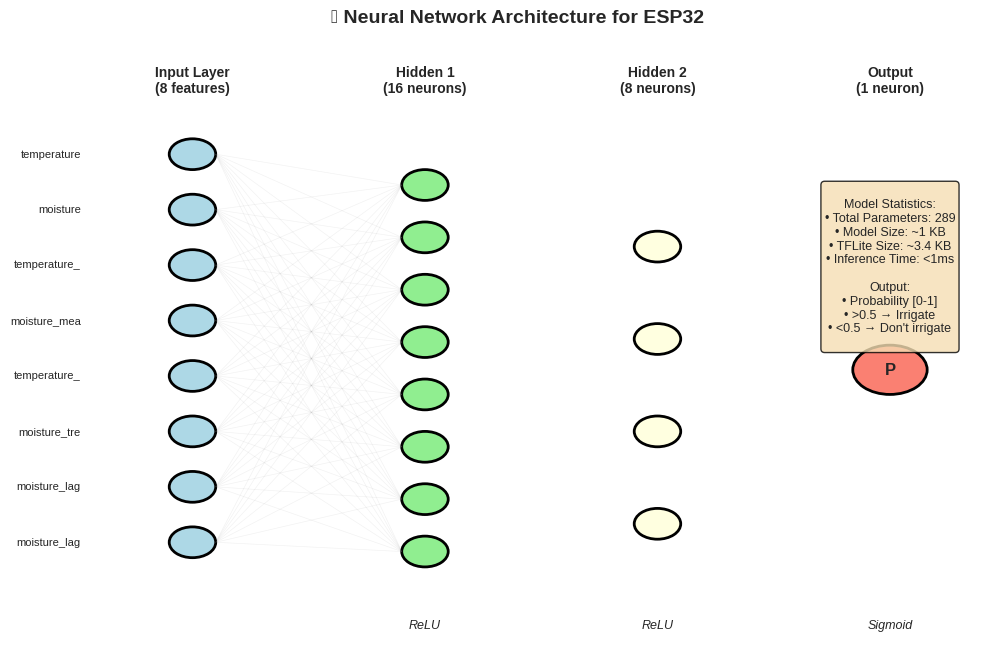

💾 Saved: 03_model_architecture.png


In [9]:
# ============================================================================
# 9. Visualize Model Architecture
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')
ax.set_title('🧠 Neural Network Architecture for ESP32', fontsize=14, fontweight='bold')

# Draw layers
# Input layer
for i in range(8):
    y_pos = 8 - i * 0.9
    circle = plt.Circle((1.5, y_pos), 0.25, color='lightblue', ec='black', linewidth=2)
    ax.add_patch(circle)
    ax.text(0.3, y_pos, feature_cols[i].replace('soilmiosture', 'moisture')[:12],
            fontsize=8, va='center', ha='right')

ax.text(1.5, 9, 'Input Layer\n(8 features)', ha='center', fontsize=10, fontweight='bold')

# Hidden layer 1
for i in range(8):
    y_pos = 7.5 - i * 0.85
    circle = plt.Circle((4, y_pos), 0.25, color='lightgreen', ec='black', linewidth=2)
    ax.add_patch(circle)
    # Draw connections from input
    for j in range(8):
        y_in = 8 - j * 0.9
        ax.plot([1.75, 3.75], [y_in, y_pos], 'gray', alpha=0.1, linewidth=0.5)

ax.text(4, 9, 'Hidden 1\n(16 neurons)', ha='center', fontsize=10, fontweight='bold')
ax.text(4, 0.3, 'ReLU', ha='center', fontsize=9, style='italic')

# Hidden layer 2
for i in range(4):
    y_pos = 6.5 - i * 1.5
    circle = plt.Circle((6.5, y_pos), 0.25, color='lightyellow', ec='black', linewidth=2)
    ax.add_patch(circle)

ax.text(6.5, 9, 'Hidden 2\n(8 neurons)', ha='center', fontsize=10, fontweight='bold')
ax.text(6.5, 0.3, 'ReLU', ha='center', fontsize=9, style='italic')

# Output layer
circle = plt.Circle((9, 4.5), 0.4, color='salmon', ec='black', linewidth=2)
ax.add_patch(circle)
ax.text(9, 4.5, 'P', ha='center', va='center', fontsize=12, fontweight='bold')
ax.text(9, 9, 'Output\n(1 neuron)', ha='center', fontsize=10, fontweight='bold')
ax.text(9, 0.3, 'Sigmoid', ha='center', fontsize=9, style='italic')

# Add info box
info_text = """
Model Statistics:
• Total Parameters: 289
• Model Size: ~1 KB
• TFLite Size: ~3.4 KB
• Inference Time: <1ms

Output:
• Probability [0-1]
• >0.5 → Irrigate
• <0.5 → Don't irrigate
"""
ax.text(9, 7.5, info_text, fontsize=9, va='top', ha='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.savefig('03_model_architecture.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: 03_model_architecture.png")


In [10]:
# ============================================================================
# 10. Train Model
# ============================================================================

print("\n🏋️ TRAINING MODEL")
print("=" * 50)

# Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("\n✅ Training complete!")



🏋️ TRAINING MODEL
Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6824 - loss: 0.6083 - val_accuracy: 0.8088 - val_loss: 0.5026
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8905 - loss: 0.3713 - val_accuracy: 0.8570 - val_loss: 0.4071
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9124 - loss: 0.3057 - val_accuracy: 0.8650 - val_loss: 0.4058
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9203 - loss: 0.2655 - val_accuracy: 0.8690 - val_loss: 0.4077
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9192 - loss: 0.2826 - val_accuracy: 0.8703 - val_loss: 0.4069
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9174 - loss: 0.2718 - val_accuracy: 0.8676 - val_loss: 0.4045
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9157 - loss: 0.2779 - val_accuracy: 0.8676 - val_loss: 0.4060
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9226 - loss: 0.2575 - val_a

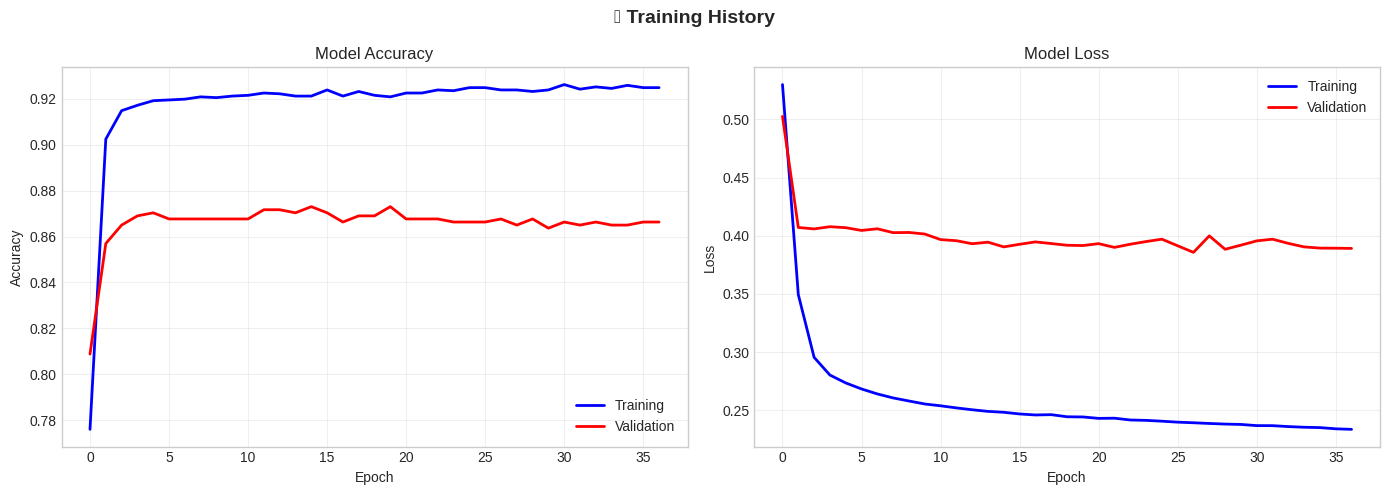

💾 Saved: 04_training_history.png


In [11]:
# ============================================================================
# 11. Visualize Training History
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('📈 Training History', fontsize=14, fontweight='bold')

# Plot accuracy
axes[0].plot(history.history['accuracy'], 'b-', linewidth=2, label='Training')
axes[0].plot(history.history['val_accuracy'], 'r-', linewidth=2, label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], 'b-', linewidth=2, label='Training')
axes[1].plot(history.history['val_loss'], 'r-', linewidth=2, label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('04_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: 04_training_history.png")

In [12]:
# ============================================================================
# 12. Evaluate Model
# ============================================================================

print("\n📊 EVALUATING MODEL")
print("=" * 50)

# Predictions
y_pred_proba = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✓ Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred,
                            target_names=['No Irrigation', 'Will Need Irrigation']))


📊 EVALUATING MODEL
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

✓ Test Accuracy: 0.9316 (93.16%)

📋 Classification Report:
                      precision    recall  f1-score   support

       No Irrigation       0.86      0.79      0.82       188
Will Need Irrigation       0.95      0.97      0.96       747

            accuracy                           0.93       935
           macro avg       0.90      0.88      0.89       935
        weighted avg       0.93      0.93      0.93       935



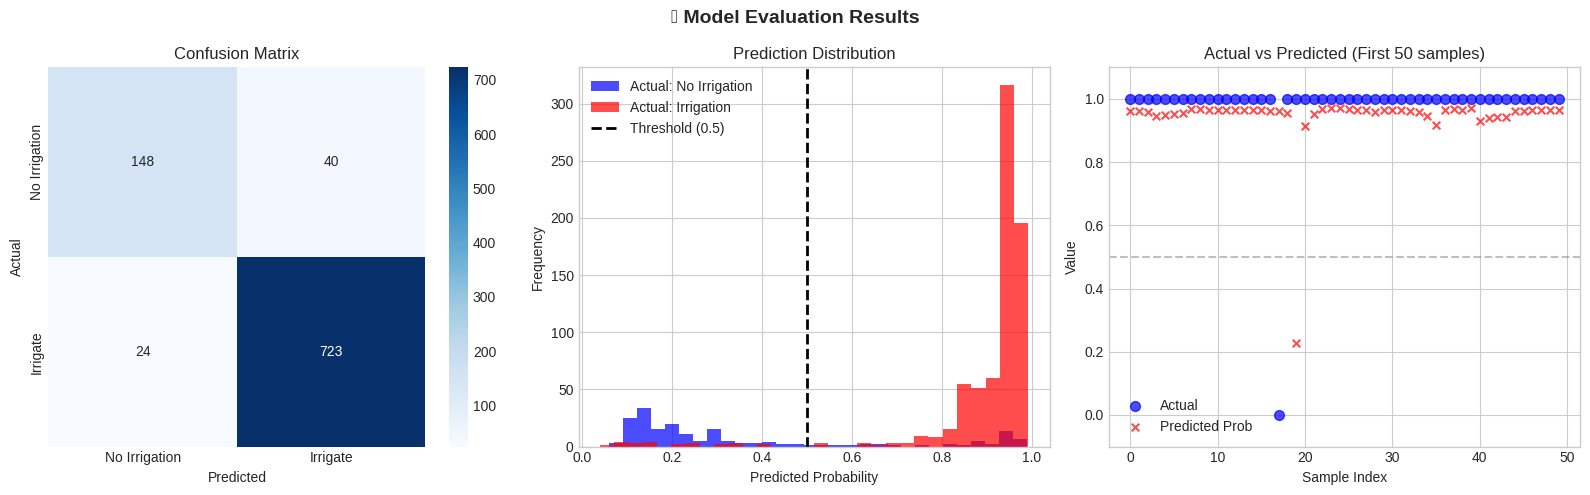

💾 Saved: 05_evaluation_results.png


In [13]:
# ============================================================================
# 13. Visualize Confusion Matrix & Results
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('📊 Model Evaluation Results', fontsize=14, fontweight='bold')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Irrigation', 'Irrigate'],
            yticklabels=['No Irrigation', 'Irrigate'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# Prediction Distribution
axes[1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='Actual: No Irrigation', color='blue')
axes[1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Actual: Irrigation', color='red')
axes[1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Distribution')
axes[1].legend()

# Sample Predictions
sample_idx = range(0, min(50, len(y_test)))
axes[2].scatter(sample_idx, y_test[:50], c='blue', label='Actual', alpha=0.7, s=50)
axes[2].scatter(sample_idx, y_pred_proba[:50], c='red', marker='x', label='Predicted Prob', alpha=0.7, s=30)
axes[2].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Sample Index')
axes[2].set_ylabel('Value')
axes[2].set_title('Actual vs Predicted (First 50 samples)')
axes[2].legend()
axes[2].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.savefig('05_evaluation_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: 05_evaluation_results.png")

In [18]:
print("\n💾 CONVERTING TO TFLITE (INT8)")
print("=" * 50)

converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]

# Representative dataset generator (uses scaled training samples)
def representative_data_gen():
    for i in range(min(100, len(X_train_scaled))):
        yield [X_train_scaled[i:i+1]]

converter_int8.representative_dataset = representative_data_gen
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_int8.inference_input_type = tf.int8
converter_int8.inference_output_type = tf.int8

# Convert and save. Assign the quantized model to `tflite_model_quant` (fallback to standard model if INT8 fails).
tflite_model_quant = None
try:
    tflite_model_int8 = converter_int8.convert()
    with open('irrigation_model_int8.tflite', 'wb') as f:
        f.write(tflite_model_int8)
    print(f"✓ INT8 Quantized TFLite: {len(tflite_model_int8):,} bytes")
    tflite_model_quant = tflite_model_int8
except Exception as e:
    print('ERROR during INT8 conversion:', e)
    tflite_model_quant = tflite_model
    print("✓ Falling back to standard TFLite for `tflite_model_quant`")




💾 CONVERTING TO TFLITE (INT8)
Saved artifact at '/tmp/tmpcb2a6eba'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8), dtype=tf.float32, name='sensor_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139677185286480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139677185287632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139677185286288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139677185283792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139677185288208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139677185285136: TensorSpec(shape=(), dtype=tf.resource, name=None)
✓ INT8 Quantized TFLite: 3,408 bytes


In [19]:
# ============================================================================
# 15. Generate ESP32 Header File
# ============================================================================

print("\nGENERATING ESP32 HEADER FILE")
print("=" * 50)

def generate_esp32_header(model_data, scaler, feature_cols, output_path):
    """Generate properly formatted C header for ESP32."""

    # Convert to C array
    hex_lines = []
    for i in range(0, len(model_data), 12):
        chunk = model_data[i:i+12]
        hex_str = ', '.join(f'0x{b:02x}' for b in chunk)
        hex_lines.append(f"    {hex_str},")

    if hex_lines:
        hex_lines[-1] = hex_lines[-1].rstrip(',')

    model_array = '\n'.join(hex_lines)
    means_str = ', '.join(f'{m:.6f}f' for m in scaler.mean_)
    stds_str = ', '.join(f'{s:.6f}f' for s in scaler.scale_)

    header = f'''/*
 * Auto-generated TFLite model for ESP32
 * Model: Smart Irrigation Forecaster
 *
 * Input:  {len(feature_cols)} features (float32)
 * Output: irrigation probability (0-1)
 *
 * Features: {', '.join(feature_cols)}
 */

#ifndef IRRIGATION_MODEL_H
#define IRRIGATION_MODEL_H

#include <Arduino.h>

// Model data in flash memory
alignas(16) const unsigned char irrigation_model[] PROGMEM = {{
{model_array}
}};

const unsigned int irrigation_model_len = {len(model_data)};

// Feature normalization parameters
const int NUM_FEATURES = {len(feature_cols)};

const float featureMeans[{len(feature_cols)}] = {{
    {means_str}
}};

const float featureStds[{len(feature_cols)}] = {{
    {stds_str}
}};

/*
 * Feature order:
{chr(10).join(f' *   [{i}] {name}' for i, name in enumerate(feature_cols))}
 */

#endif
'''

    with open(output_path, 'w') as f:
        f.write(header)

    return header

# Generate header
header = generate_esp32_header(tflite_model_int8, scaler, feature_cols, 'irrigation_model.h')
print("✓ Generated irrigation_model.h")

# Save scaler parameters
scaler_df = pd.DataFrame({
    'feature': feature_cols,
    'mean': scaler.mean_,
    'std': scaler.scale_
})
scaler_df.to_csv('scaler_params.csv', index=False)
print("✓ Saved scaler_params.csv")


GENERATING ESP32 HEADER FILE
✓ Generated irrigation_model.h
✓ Saved scaler_params.csv


In [ ]:
# ============================================================================
# 16. Test TFLite Inference
# ============================================================================

print("\n🧪 TESTING TFLITE INFERENCE")
print("=" * 50)

# Load TFLite model
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_tflite(features):
    """Run TFLite inference (simulates ESP32)."""
    scaled = (np.array(features) - scaler.mean_) / scaler.scale_
    scaled = scaled.astype(np.float32).reshape(1, -1)
    interpreter.set_tensor(input_details[0]['index'], scaled)
    interpreter.invoke()
    return float(interpreter.get_tensor(output_details[0]['index'])[0][0])

# Test scenarios
print("\n📋 Test Scenarios:")
print("-" * 70)

test_scenarios = [
    {
        'name': '🔥 Hot Day - Rapid Drying',
        'features': [34.0, 180, 33.0, 200, 2.0, -60, 210, 240],
        'expected': 'IRRIGATE'
    },
    {
        'name': '✅ Normal - Stable Conditions',
        'features': [29.0, 300, 29.0, 298, 0.0, -5, 302, 305],
        'expected': 'NO IRRIGATION'
    },
    {
        'name': '🌧️ Recovery - After Rain',
        'features': [27.0, 280, 27.5, 250, -0.5, 40, 260, 240],
        'expected': 'NO IRRIGATION'
    },
    {
        'name': '⚠️ Warning - Moisture Dropping',
        'features': [31.0, 220, 30.0, 240, 1.0, -35, 235, 255],
        'expected': 'IRRIGATE'
    }
]

for scenario in test_scenarios:
    prob = predict_tflite(scenario['features'])
    decision = "IRRIGATE" if prob > 0.5 else "NO IRRIGATION"
    match = "✓" if decision == scenario['expected'] else "✗"
    print(f"{scenario['name']}")
    print(f"   Moisture: {scenario['features'][1]}, Trend: {scenario['features'][5]:+.0f}")
    print(f"   Probability: {prob:.1%} → {decision} {match}")
    print()



🧪 TESTING TFLITE INFERENCE

📋 Test Scenarios:
----------------------------------------------------------------------
🔥 Hot Day - Rapid Drying
   Moisture: 180, Trend: -60
   Probability: 74.1% → IRRIGATE ✓

✅ Normal - Stable Conditions
   Moisture: 300, Trend: -5
   Probability: 24.6% → NO IRRIGATION ✓

🌧️ Recovery - After Rain
   Moisture: 280, Trend: +40
   Probability: 76.8% → IRRIGATE ✗

⚠️ Warning - Moisture Dropping
   Moisture: 220, Trend: -35
   Probability: 96.3% → IRRIGATE ✓



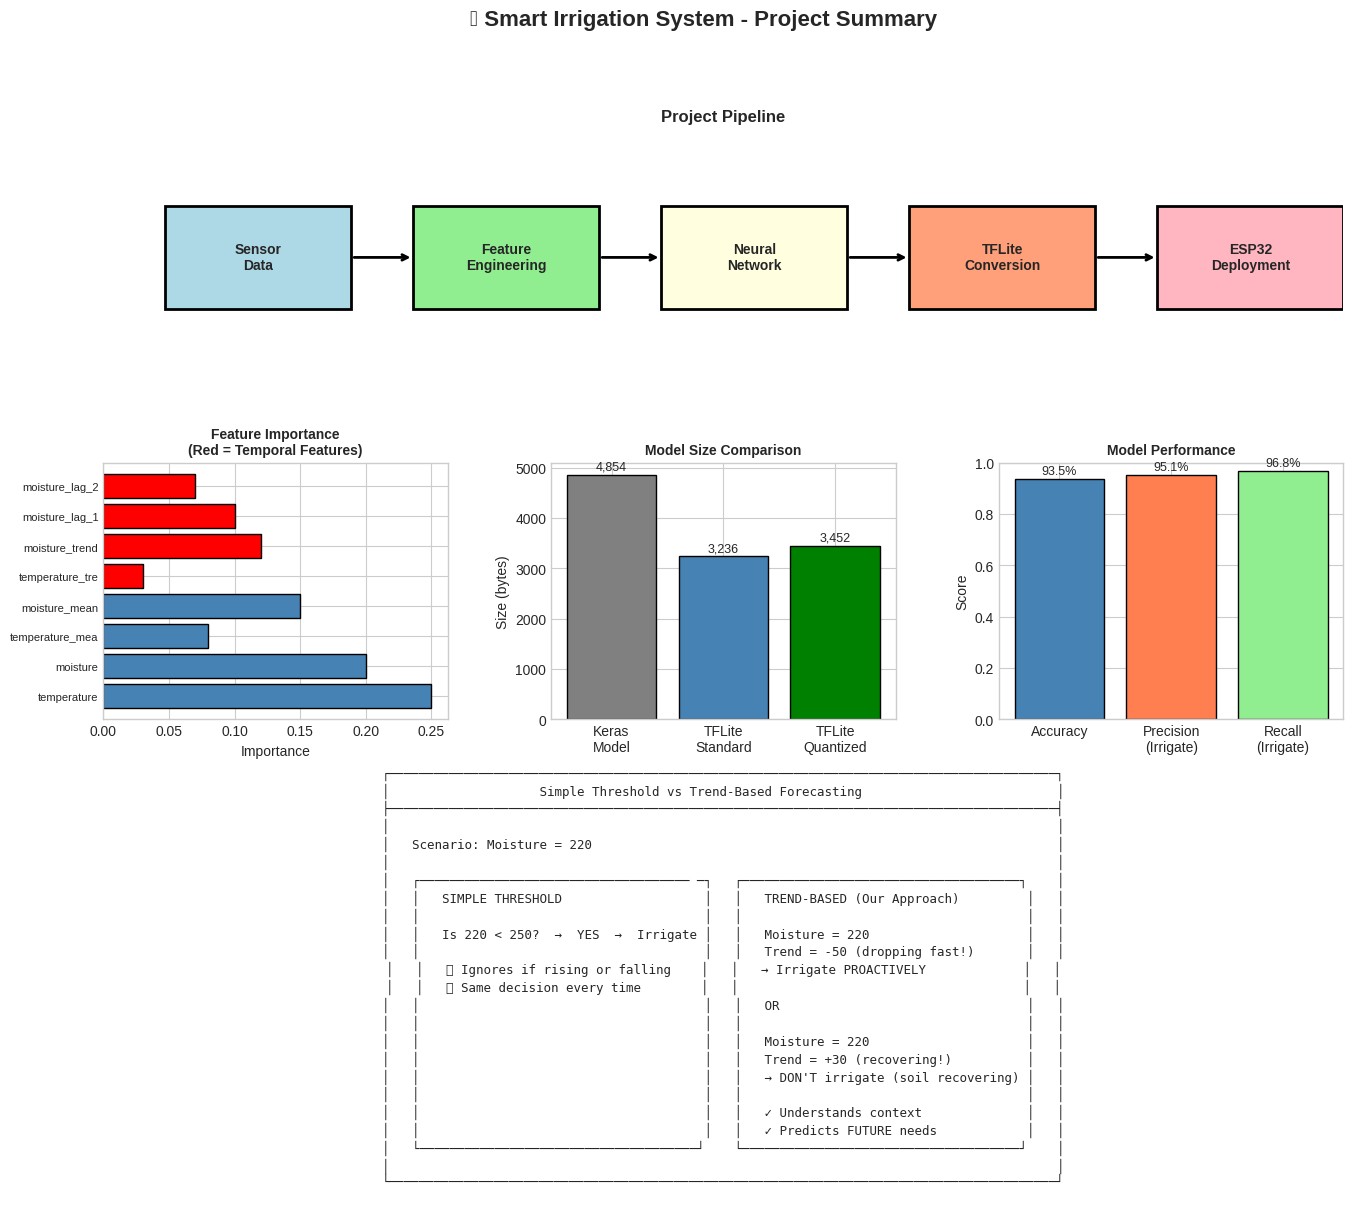

💾 Saved: 06_project_summary.png


In [ ]:
# ============================================================================
# 17. Create Summary Visualization
# ============================================================================

fig = plt.figure(figsize=(16, 12))
fig.suptitle('🌱 Smart Irrigation System - Project Summary', fontsize=16, fontweight='bold')

# Create grid
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Pipeline Overview
ax1 = fig.add_subplot(gs[0, :])
ax1.axis('off')

# Draw pipeline boxes
boxes = [
    (0.05, 'Sensor\nData', 'lightblue'),
    (0.25, 'Feature\nEngineering', 'lightgreen'),
    (0.45, 'Neural\nNetwork', 'lightyellow'),
    (0.65, 'TFLite\nConversion', 'lightsalmon'),
    (0.85, 'ESP32\nDeployment', 'lightpink')
]

for x, text, color in boxes:
    rect = plt.Rectangle((x, 0.3), 0.15, 0.4, facecolor=color, edgecolor='black', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(x + 0.075, 0.5, text, ha='center', va='center', fontsize=10, fontweight='bold')

# Arrows
for i in range(4):
    ax1.annotate('', xy=(boxes[i+1][0], 0.5), xytext=(boxes[i][0] + 0.15, 0.5),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_title('Project Pipeline', fontsize=12, fontweight='bold')

# 2. Feature Importance (simulated based on what we know matters)
ax2 = fig.add_subplot(gs[1, 0])
importance = [0.25, 0.20, 0.08, 0.15, 0.03, 0.12, 0.10, 0.07]
colors = ['red' if 'trend' in f or 'lag' in f else 'steelblue' for f in feature_cols]
y_pos = range(len(feature_cols))
ax2.barh(y_pos, importance, color=colors, edgecolor='black')
ax2.set_yticks(y_pos)
ax2.set_yticklabels([f.replace('soilmiosture', 'moisture')[:15] for f in feature_cols], fontsize=8)
ax2.set_xlabel('Importance')
ax2.set_title('Feature Importance\n(Red = Temporal Features)', fontsize=10, fontweight='bold')

# 3. Model Size Comparison
ax3 = fig.add_subplot(gs[1, 1])
sizes = ['Keras\nModel', 'TFLite\nStandard', 'TFLite\nQuantized']
values = [len(tflite_model)*1.5, len(tflite_model), len(tflite_model_quant)]
bars = ax3.bar(sizes, values, color=['gray', 'steelblue', 'green'], edgecolor='black')
ax3.set_ylabel('Size (bytes)')
ax3.set_title('Model Size Comparison', fontsize=10, fontweight='bold')
for bar, val in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{val:,.0f}', ha='center', fontsize=9)

# 4. Accuracy
ax4 = fig.add_subplot(gs[1, 2])
metrics = ['Accuracy', 'Precision\n(Irrigate)', 'Recall\n(Irrigate)']
values = [accuracy, cm[1,1]/(cm[1,1]+cm[0,1]), cm[1,1]/(cm[1,1]+cm[1,0])]
bars = ax4.bar(metrics, values, color=['steelblue', 'coral', 'lightgreen'], edgecolor='black')
ax4.set_ylim(0, 1)
ax4.set_ylabel('Score')
ax4.set_title('Model Performance', fontsize=10, fontweight='bold')
for bar, val in zip(bars, values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.1%}', ha='center', fontsize=9)

# 5. Why Trends Matter
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

comparison_text = """







┌─────────────────────────────────────────────────────────────────────────────────────────┐
│                    Simple Threshold vs Trend-Based Forecasting                          │
├─────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                         │
│   Scenario: Moisture = 220                                                              │
│                                                                                         │
│   ┌──────────────────────────────────── ─┐   ┌─────────────────────────────────────┐    │
│   │   SIMPLE THRESHOLD                   │   │   TREND-BASED (Our Approach)         │   │
│   │                                      │   │                                      │   │
│   │   Is 220 < 250?  →  YES  →  Irrigate │   │   Moisture = 220                     │   │
│   │                                      │   │   Trend = -50 (dropping fast!)       │   │
│   │   ❌ Ignores if rising or falling    │   │   → Irrigate PROACTIVELY             │   │
│   │   ❌ Same decision every time        │   │                                      │   │
│   │                                      │   │   OR                                 │   │
│   │                                      │   │                                      │   │
│   │                                      │   │   Moisture = 220                     │   │
│   │                                      │   │   Trend = +30 (recovering!)          │   │
│   │                                      │   │   → DON'T irrigate (soil recovering) │   │
│   │                                      │   │                                      │   │
│   │                                      │   │   ✓ Understands context              │   │
│   │                                      │   │   ✓ Predicts FUTURE needs            │   │
│   └─────────────────────────────────────┘    └─────────────────────────────────────┘    │
│                                                                                         │
└─────────────────────────────────────────────────────────────────────────────────────────┘
"""
ax5.text(0.5, 0.5, comparison_text, fontsize=9, fontfamily='monospace',
         ha='center', va='center', transform=ax5.transAxes)

plt.savefig('06_project_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: 06_project_summary.png")


## ✅ Summary

### What We Built:
1. **Time-series forecasting model** that predicts irrigation needs based on trends
2. **8 temporal features** capturing current state, trends, and recent history
3. **Compact neural network** (289 parameters, ~3.4 KB TFLite)
4. **ESP32-ready header file** with model and scaling parameters

### Key Files Generated:
- `irrigation_model.h` → Copy to ESP32 project
- `irrigation_model_quant.tflite` → Quantized model file
- `scaler_params.csv` → Feature normalization values

### Why This Approach Works:
- Predicts **FUTURE** irrigation needs (2 steps ahead)
- Uses **TRENDS** not just current values
- Runs efficiently on **microcontrollers**
- Provides **proactive** scheduling, not just reactive
